# Crop Landcover Exploration

This notebook contains some exploratory data analysis for this problem. Our goal is to build and understand a model for predicting crop types for fields in South Africa, based on satellite imagery from the [Sentinel 2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) product.

Our labels come from the Radiant Earth [South Africa Crop Type Competition](https://registry.mlhub.earth/10.34911/rdnt.j0co8q/). They're a collection of scenes, with integers indicating the crop type at each pixel in the scene.

Our training data comes from Microsoft's Planetary Computer. The [Sentinel 2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) page describes what all is avaiable.

## Data Access

We'll use [STAC](https://stacspec.org/) to easily find and load the data we care about. We'll interact with two STAC catalogs

1. A catalog for the labels, hosted in a Blob Storage container
2. The Planetary Computer's STAC API, which catalogs all of Sentinel 2 Level 2-A (among [many other collections](https://planetarycomputer.microsoft.com/catalog))

The overall workflow will be

1. Load a scene with the label data (a 256x256 array of integer codes indicate the crop type)
2. Search for and load a scene with Sentinel 2 imagery
3. Transform and crop the (very large) Sentinel 2 scene to match the 256x256 label scene

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import warnings

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Load Labels

We have a STAC catalog of labels for the training data, which is based off the collection used in the Radiant Earth competition.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/"
    "train/collection.json"
)
training_catalog

<Collection id=ref_south_africa_crops_competition_v1_train_labels>

That catalog has links to a bunch of Items, where each item represents a scene.

In [3]:
label_links = training_catalog.get_item_links()
len(label_links)

2000

We can get the label `Item` by following the link. Item 18 happens to look interesting.

In [4]:
label_item = label_links[18].resolve_stac_object().target
label_item

<Item id=ref_south_africa_crops_competition_v1_train_labels_2128>

### Exercise: Explore the pystac.Item

* What's the item's bounding box? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.bbox)
* When was the item captured? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.datetime)
* What assets does the item have? (See https://pystac.readthedocs.io/en/latest/api.html#pystac.Item.assets)

In [5]:
# what is the item's bounding box?
label_item.bbox

[18.46447947403402, -32.55273603831489, 18.49236223306772, -32.529118087556135]

In [6]:
# what is the item's date?
label_item.datetime

datetime.datetime(2017, 8, 1, 0, 0, tzinfo=tzlocal())

In [7]:
# what assets does the item have?
label_item.assets

{'documentation': <Asset href=../_common/documentation.pdf>,
 'field_ids': <Asset href=./field_ids.tif>,
 'field_info_train': <Asset href=../../home/jovyan/mlhub/ref_south_africa_crops_competition_v1_train_labels/_common/field_info_train.csv>,
 'labels': <Asset href=./labels.tif>,
 'raster_values': <Asset href=../_common/raster_values.json>}

We're interested in the `labels` asset, which has the Cloud Optimied GeoTiff of integers indicating the crop type at each pixel. Let's load the URL pointed to by that asset into an `xarray.DataArray` using `rioxarray.open_rasterio`.

In [8]:
import rioxarray

label_item = training_catalog.links[19].resolve_stac_object().target
labels = rioxarray.open_rasterio(
    label_item.assets['labels'].get_absolute_href()
).squeeze()
labels

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
  * y            (y) float64 -3.602e+06 -3.602e+06 ... -3.604e+06 -3.604e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Let's plot the `labels` to see what we're working with.

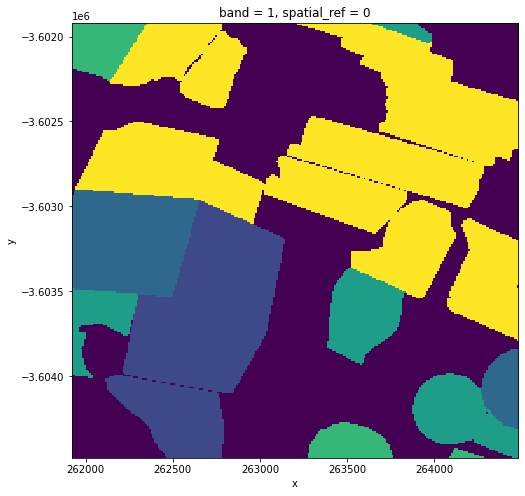

In [9]:
labels.plot.imshow(figsize=(8, 8), add_colorbar=False);

As we discovered, that item is from a specific date / time. We'll search for Sentinel-2 scenes in the Planetary Computer's catalog overlapping with our training labels around that datetime. We'll use `pystac-client` to make this easier. First, we define a client to work with the endpoint:

In [10]:
import pystac_client

stac_client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

In [11]:
search = stac_client.search(
    collections=["sentinel-2-l2a"],
    bbox=label_item.bbox,
    datetime="2017-07-01/2017-09-01",
    limit=500,
)

Let's find a scene with few clouds. That information is available under the `EOExtension`.

In [12]:
from pystac.extensions.eo import EOExtension

items = search.get_all_items()
sentinel_item = sorted(
    items,
    key=lambda item: EOExtension.ext(item).cloud_cover
)[0]

And now visualize the Sentinel scene, overlaying the bounding box of the label scene.

In [13]:
sentinel_item.assets['tilejson'].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=sentinel-2-l2a&items=S2B_MSIL2A_20170728T082559_R021_T34HBK&assets=visual-10m&bidx=1,2,3&nodata=0'

In [14]:
from ipyleaflet import Map, TileLayer, GeoJSON

center = shapely.geometry.shape(
    label_item.geometry
).centroid.bounds[:2][::-1]

m = Map(center=center, zoom=12)
layer = TileLayer(
    url=requests.get(sentinel_item.assets['tilejson'].href).json()['tiles'][0],
)
m.add_layer(layer)
m.add_layer(GeoJSON(data=label_item.geometry))
m

Map(center=[-32.54092743431243, 18.47842261141666], controls=(ZoomControl(options=['position', 'zoom_in_text',…

We have a bit of work to align the training labels and the image. First, the coordinate reference system (`epsg` code) doesn't match.

In [15]:
from pystac.extensions.projection import ProjectionExtension
print("  Labels CRS:", labels.rio.crs.to_epsg())
print("Sentinel CRS:", ProjectionExtension.ext(sentinel_item).epsg)

  Labels CRS: 32634
Sentinel CRS: 32734


We'll try to do everything in the coordinates of the labels. As we load the training data into a DataArray, we'll reproject it to the labels' CRS. We'll also trim it down to just the bit we need, covering the labels scene, to avoid using too much memory. `stackstac` handles all of this for us.

In [16]:
import planetary_computer
import stackstac

assets = ["B02", "B03", "B04", "B05", "B06", "B07", "B09"]
data = stackstac.stack(
    planetary_computer.sign(sentinel_item).to_dict(),
    assets=assets,
    dtype="float32",
    resolution=10,                  # resample all assets to the highest resolution
    epsg=labels.rio.crs.to_epsg(),  # reproject to the labels CRS
    bounds=labels.rio.bounds(),     # crop to the labels' bounds
).where(lambda x: x > 0).squeeze()

assert data.shape[1:] == labels.shape

data = data.compute()
data

<xarray.DataArray 'stackstac-425dfd5fdc5afe3ccb9a7477fb37b844' (band: 7, y: 256, x: 256)>
array([[[ 589.,  573.,  533., ...,  901.,  377.,  526.],
        [ 437.,  443.,  438., ...,  857.,  643.,  520.],
        [ 379.,  410.,  434., ...,  883.,  773.,  513.],
        ...,
        [ 480.,  517.,  455., ...,  888.,  948.,  730.],
        [ 344.,  504.,  469., ...,  724.,  760.,  620.],
        [ 120.,  277.,  260., ...,  652.,  673.,  608.]],

       [[1176., 1156., 1152., ..., 1246.,  608.,  732.],
        [1110., 1084., 1106., ..., 1266.,  750.,  708.],
        [1021., 1072., 1092., ..., 1158., 1232.,  730.],
        ...,
        [ 589.,  659.,  600., ..., 1234., 1344., 1128.],
        [ 394.,  647.,  618., ..., 1294., 1256., 1042.],
        [ 182.,  325.,  353., ...,  989., 1068.,  961.]],

       [[1004.,  932.,  897., ..., 1632.,  777.,  962.],
        [ 780.,  780.,  750., ..., 1518., 1152.,  933.],
        [ 654.,  747.,  713., ..., 1568., 1404.,  965.],
        ...,
...
        ...,
        [1260., 1260., 1374., ..., 2796., 2827., 2827.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.]],

       [[4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4765., 4765., 4769., ..., 1880., 1963., 1963.],
        ...,
        [1315., 1315., 1397., ..., 3045., 2952., 2952.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.]],

       [[4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        ...,
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.]]], dtype=float32)
Coordinates: (12/46)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * band                                     (band) <U3 'B02' 'B03' ... 'B09'
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
  * y                                        (y) float64 -3.602e+06 ... -3.60...
    s2:processing_baseline                   <U5 '02.12'
    ...                                       ...
    proj:transform                           (band) object None ... [60.0, 0....
    gsd                                      (band) object None None ... 20 60
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) float64 0.49 0.56 ... 0.945
    full_width_half_max                      (band) float64 0.098 ... 0.026
    epsg                                     int64 32634
Attributes:
    spec:        RasterSpec(epsg=32634, bounds=(261920, -3604480, 264480, -36...
    crs:         epsg:32634
    transform:   | 10.00, 0.00, 261920.00|\n| 0.00,-10.00,-3601920.00|\n| 0.0...
    resolution:  10

Our shapes match (256 x 256 patch), but the labels don't quite.

In [17]:
labels.x

<xarray.DataArray 'x' (x: 256)>
array([261925., 261935., 261945., ..., 264455., 264465., 264475.])
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
    spatial_ref  int64 0

In [18]:
data.x

<xarray.DataArray 'x' (x: 256)>
array([261920., 261930., 261940., ..., 264450., 264460., 264470.])
Coordinates: (12/37)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
    s2:processing_baseline                   <U5 '02.12'
    proj:epsg                                int64 32734
    s2:datastrip_id                          <U64 'S2B_OPER_MSI_L2A_DS_ESRI_2...
    ...                                       ...
    s2:degraded_msi_data_percentage          float64 0.0
    s2:mean_solar_zenith                     float64 57.79
    s2:granule_id                            <U62 'S2B_OPER_MSI_L2A_TL_ESRI_2...
    s2:mean_solar_azimuth                    float64 32.11
    proj:bbox                                object {6500020.0, 6390220.0, 19...
    epsg                                     int64 32634

They're off by half a pixel (5 units in coordinate space). This probably just comes from one dataset labeling the center of the pixel and the other labeling the top-left corner. It'd be good to verify that. In the meantime, let's just update the labels on `data`

In [19]:
data2 = (
    data.assign_coords(
        y=lambda ds: (ds.y - 5).round(),   # fix half-pixel label issue
        x=lambda ds: (ds.x + 5).round(),
    )
)

Now we should be all set.

In [20]:
assert (data2.x.data == labels.x.data).all()
assert (data2.y.data == labels.y.data).all()

And we can spot-check out transformation visually. Let's plot the Red band.

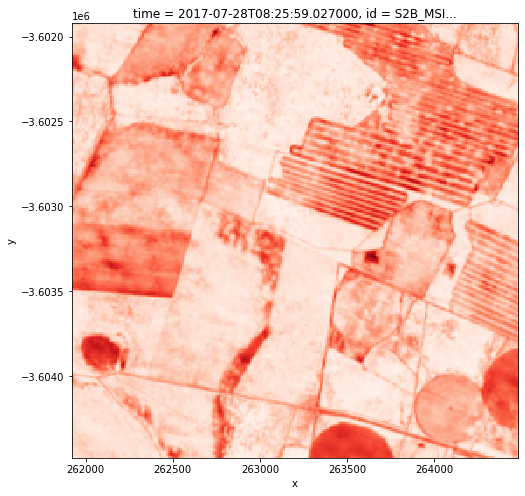

In [21]:
data2.sel(band="B04").plot.imshow(figsize=(8, 8), cmap="Reds", add_colorbar=False);

Which looks pretty close to what we want.

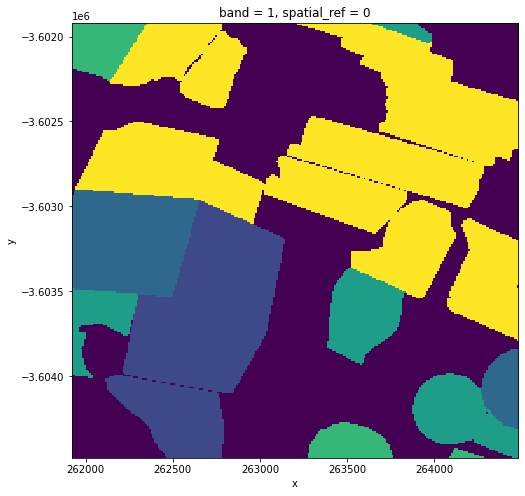

In [22]:
labels.plot.imshow(figsize=(8, 8), add_colorbar=False);

## Train a Baseline Model

We've come this far, we might as well do some machine learning! We'll use a scikit-learn K-Nearest Neighbors classifier to establish a baseline model for this dataset.

In [23]:
import sklearn.neighbors
import sklearn.model_selection

As usual with scikit-learn, the estimator expects an intput array of `(n_samples, n_features)`. In this case a "sample" will be a single pixel, and the feature will be all the bands. We'll get to that shape by stacking all the the pixels into one long array.

In [24]:
X = data2.stack(pixel=("y", "x")).T
X.shape

(65536, 7)

We'll also reshape the labels to be a 1-D array `(n_features,)`

In [25]:
y = labels.stack(pixel=("y", "x"))
y.shape

(65536,)

In [26]:
assert X.indexes['pixel'].equals(y.indexes['pixel'])

### Exercise: Train a model

Use scikit-learn to split the data into a training and test dataset.

In [27]:
# split `X` and `y` into train and test sets
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [28]:
# fit the KNeighborsClassifier
nn = sklearn.neighbors.KNeighborsClassifier()
nn.fit(X_train, y_train)

KNeighborsClassifier()

In [29]:
# Check the score on the training dataset
nn.score(X_train, y_train)

0.89447021484375

In [30]:
# Check the score on the test dataset
nn.score(X_test, y_test)

0.839111328125

We're overfitting a bit (89% on our training dataset, 84% on our test), but not too bad. Let's visualize the predictions.

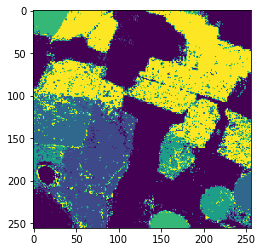

In [31]:
import rasterio.plot

yhat = nn.predict(X)

rasterio.plot.show(
    yhat.reshape(labels.shape)
);

Not *awful*, but certainly room for improvement. A few things to note:

1. We haven't done any fancy preprocessing (e.g. mosaicing scenes to remove clouds) that could improve this model.
2. We haven't done any fancy hyper-parameter tuning that could improve this model.
3. We aren't using the spatial "context" of each pixel at all, which leads to the splotchiness in our predictions. If a pixel is surrounded on all sides by Wheat pixels, then it's probably a Wheat pixel. But our current model has no idea about the neighboring pixels.
4. There's a lot of variation across the scenes in the label data. Our model hasn't seen any of those, so likely won't generalize well to them. We'd need to train on more data.